Here we will build a connectivity analysis pipeline for the KPE study. 
Methods should be easily generalized for others studies. 


In [3]:
## Use this box if you want MDSL
# using MSDL atlas - Can choose different atlas or different nodes (using ICA or something else)
from nilearn import datasets
atlas = datasets.fetch_atlas_msdl()

# Loading atlas image stored in 'maps'
atlas_filename = atlas['maps']
# Loading atlas data stored in 'labels'
#labels_img=yeo['thick_17']
labels =  atlas['labels']
coords = atlas.region_coords# grab center coordinates for atlas labels
#coords = plotting.find_parcellation_cut_coords(labels_img=labels)
#atlas.region_coords

# optional set of different atlas
#atlas_yeo_2011 = 
#atlas_yeo = atlas_yeo_2011.thick_7

/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/numpy/lib/npyio.py:2322: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [4]:
print(labels)
print(labels.index("Med DMN")) # print index of Med DMN 
print(labels.index("V ACC"))

['L Aud', 'R Aud', 'Striate', 'L DMN', 'Med DMN', 'Front DMN', 'R DMN', 'Occ post', 'Motor', 'R DLPFC', 'R Front pol', 'R Par', 'R Post Temp', 'Basal', 'L Par', 'L DLPFC', 'L Front pol', 'L IPS', 'R IPS', 'L LOC', 'Vis', 'R LOC', 'D ACC', 'V ACC', 'R A Ins', 'L STS', 'R STS', 'L TPJ', 'Broca', 'Sup Front S', 'R TPJ', 'R Pars Op', 'Cereb', 'Dors PCC', 'L Ins', 'Cing', 'R Ins', 'L Ant IPS', 'R Ant IPS']
4
23


In [ ]:
# Run either this or MSDL - not both boxes
# try to use Shen atlas
# import pandas as pd

# atlas_filename = '/home/oad4/nilearn_data/shenParcellation/shen_2mm_268_parcellation.nii.gz'
# atlas_labes = pd.read_csv('/home/oad4/nilearn_data/shenParcellation/shen_268_parcellation_networklabels.csv')
# coords = plotting.find_parcellation_cut_coords(labels_img=atlas_filename)

# atlas_labes = np.array(atlas_labes)
# atlas_labes

In [5]:
import os
import numpy as np

In [6]:
# methods
def removeVars (confoundFile):
    # this method takes the csv regressors file (from fmriPrep) and chooses a few to confound. You can change those few
    import pandas as pd
    confound = pd.read_csv(confoundFile,sep="\t", na_values="n/a")
    finalConf = confound[['csf', 'white_matter', 'framewise_displacement',
                          'a_comp_cor_00', 'a_comp_cor_01',	'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', 
                        'a_comp_cor_05', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']] # can add 'global_signal' also
     # change NaN of FD to zero
    finalConf = np.array(finalConf)
    finalConf[0,2] = 0
    return finalConf

In [195]:
# build method for creating time series for subjects
def timeSeries(func_files, confound_files):
    total_subjects = [] # creating an empty array that will hold all subjects matrix 
    # This function needs a masker object that will be defined outside the function
    for func_file, confound_file in zip(func_files, confound_files):
        print(f"proccessing file {func_file}") # print file name
        confoundClean = removeVars(confound_file)
        confoundArray = confoundClean#confoundClean.values
        time_series = masker.fit_transform(func_file, confounds=confoundArray)
        #time_series = extractor.fit_transform(func_file, confounds=confoundArray)
        #masker.fit_transform(func_file, confoundArray)
        total_subjects.append(time_series)
    return total_subjects

# contrasting two timePoints
def contFuncs(time_series1, time_series2):
    twoMinusOneMat = []
    for scanMatrix, scanMatrix2 in zip(time_series1, time_series2):
        a = scanMatrix2 - scanMatrix
        twoMinusOneMat.append(a)
    return np.array(twoMinusOneMat)

import numpy as np
from nilearn import plotting

# create correlation matrix per subject
def createCorMat(time_series):
    # create correlation matrix for each subject
    fullMatrix = []
    for time_s in time_series:
        correlation_matrix = correlation_measure.fit_transform([time_s])[0]
        fullMatrix.append(correlation_matrix)
    return fullMatrix

# create connecotme graph per subject
def connectome_graph (fullMatrix):
    # here it is set to threshold 1%
    for matrix in fullMatrix:
        plotting.plot_connectome(matrix, coords,
                             edge_threshold="99%", colorbar=True)
        plotting.show()

In [194]:
# Here you set the specific methods for masking and correlation. Please see Nilearn website for more info.

from nilearn.input_data import NiftiMapsMasker
from nilearn.input_data import NiftiLabelsMasker
# in this mask we standardize the values, so mean is 0 and between -1 to 1
masker = NiftiMapsMasker(maps_img=atlas_filename, standardize=True, smoothing_fwhm = 6,
                         memory="/home/oad4/scratch60/nilearn",high_pass=.01 , low_pass = .1, t_r=1, verbose=5)

# use different masker when using Yeo atlas. 
#masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,smoothing_fwhm = 6,
 #                        memory="/home/oad4/scratch60/nilearn",high_pass=.01 , low_pass = .1, t_r=1, verbose=5)
                           
from nilearn.connectome import ConnectivityMeasure
#correlation_measure = ConnectivityMeasure(kind='partial correlation') # can choose partial - it might be better
correlation_measure = ConnectivityMeasure(kind='correlation') # can choose partial - it might be better


In [9]:
# now we call subjcets
# and start the real analysis
subList =  ['008','1293','1307','1322','1339','1343','1387','1223']
midSubList = ['1253','1263','1351','1356','1364','1369','1390','1403']

# these two functions take subject list and session number (in string) and return func file list and confound file list
def fileList(subjects, session):
    func_files = ['/home/oad4/scratch60/kpeOutput/fmriprep/sub-%s/ses-%s/func/sub-%s_ses-%s_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz' % (sub,session,sub,session) for sub in subjects]
    return func_files

def confList(subjects, session):
    confound_files = ['/home/oad4/scratch60/kpeOutput/fmriprep/sub-%s/ses-%s/func/sub-%s_ses-%s_task-rest_desc-confounds_regressors.tsv' % (sub,session,sub,session) for sub in subjects]
    return confound_files


In [10]:
# now we call for the functions for each set.
# for every time line we want to run time series and then contrast between the times
ket1_series = timeSeries(func_files=fileList(subList,'1'), confound_files=confList(subList, '1'))

proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-008/ses-1/func/sub-008_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii
Resampling maps
[Memory]0.1s, 0.0min    : Loading resample_img...


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:84: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/home/oad4/scratch60/nilearn'", use "location='/home/oad4/scratch60/nilearn'" instead.
  memory = Memory(cachedir=cache_dir, verbose=verbose)
/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:
/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:302: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is curre

________________________________________resample_img cache loaded - 3.3s, 0.1min
[Memory]4.1s, 0.1min    : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1293/ses-1/func/sub-1293_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]16.5s, 0.3min   : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1307/ses-1/func/sub-1307_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]29.4s, 0.5min   : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1322/ses-1/func/sub-1322_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]40.7s, 0.7min   : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1339/ses-1/func/sub-1339_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]52.7s, 0.9min   : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1343/ses-1/func/sub-1343_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]65.1s, 1.1min   : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1387/ses-1/func/sub-1387_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]77.9s, 1.3min   : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1223/ses-1/func/sub-1223_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('/home/oad4/scratch60/kpeOutput/fmriprep/sub-1223/ses-1/func/sub-1223_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 
{ 'allow_overlap': True,
  'detrend': False,
  'dtype': None,
  'high_pass': 0.01,
  'low_pass': 0.1,
  'maps_img': '/home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii',
  'mask_img': None,
  'smoothing_fwhm': 6,
  'standardize': True,
  't_r': 1,
  'target_affine': None,
  'target_shape': None}, confounds=array([[ 5.422168e+03, ...,  0.000000e+00],
       ...,
       [ 5.316874e+03, ..., -2.285370e-03]]), dtype=None, memory=Memory(location=/home/oad4/scratch60/nilearn/joblib), memory_level=1, verbose=5)
[NiftiMapsMasker.transform_single_imgs] Loading data from /home/oad4/scratch60/kpeOutput/fmriprep/sub-1223/ses-1/func/sub-1223_ses-1_task-rest_space-MNI152NLin2009cAsym_des

/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/input_data/nifti_maps_masker.py:326: UserWarning: Persisting input arguments took 3.73s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


In [11]:
ket2_series = timeSeries(func_files=fileList(subList,'2'), confound_files=confList(subList, '2'))

proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-008/ses-2/func/sub-008_ses-2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]207.3s, 3.5min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1293/ses-2/func/sub-1293_ses-2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]220.5s, 3.7min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1307/ses-2/func/sub-1307_ses-2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]233.8s, 3.9min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1322/ses-2/func/sub-1322_ses-2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]246.0s, 4.1min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1339/ses-2/func/sub-1339_ses-2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]258.3s, 4.3min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1343/ses-2/func/sub-1343_ses-2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]271.5s, 4.5min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1387/ses-2/func/sub-1387_ses-2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]284.8s, 4.7min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1223/ses-2/func/sub-1223_ses-2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]297.9s, 5.0min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


In [12]:
ket3_series = timeSeries(func_files=fileList(subList,'3'), confound_files=confList(subList, '3'))

proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-008/ses-3/func/sub-008_ses-3_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]310.7s, 5.2min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1293/ses-3/func/sub-1293_ses-3_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]323.7s, 5.4min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1307/ses-3/func/sub-1307_ses-3_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]337.5s, 5.6min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1322/ses-3/func/sub-1322_ses-3_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]349.7s, 5.8min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1339/ses-3/func/sub-1339_ses-3_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]362.0s, 6.0min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1343/ses-3/func/sub-1343_ses-3_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]375.0s, 6.3min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1387/ses-3/func/sub-1387_ses-3_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]388.0s, 6.5min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1223/ses-3/func/sub-1223_ses-3_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]400.7s, 6.7min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


In [13]:
subListKet4 =  ['008','1293','1307','1322','1339','1343','1223']
ket4_series = timeSeries(func_files=fileList(subListKet4,'4'), confound_files=confList(subListKet4, '4'))

proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-008/ses-4/func/sub-008_ses-4_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]413.9s, 6.9min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1293/ses-4/func/sub-1293_ses-4_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]427.3s, 7.1min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1307/ses-4/func/sub-1307_ses-4_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]441.0s, 7.4min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1322/ses-4/func/sub-1322_ses-4_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]453.2s, 7.6min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1339/ses-4/func/sub-1339_ses-4_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]456.3s, 7.6min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1343/ses-4/func/sub-1343_ses-4_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]469.4s, 7.8min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1223/ses-4/func/sub-1223_ses-4_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]482.1s, 8.0min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


In [196]:
# build correlation matrix for each time point
ket1_corr = createCorMat(ket1_series)
ket2_corr = createCorMat(ket2_series)
ket3_corr = createCorMat(ket3_series)
ket4_corr = createCorMat(ket4_series)

In [197]:
# start contrasting
ket2_ket1 = contFuncs(ket1_corr, ket2_corr)
ket3_ket1 = contFuncs(ket1_corr, ket3_corr)

ket3_ket1.shape


(8, 39, 39)

In [ ]:
plotting.plot_connectome(np.average(ket2_ket1, axis=0), coords,
                         edge_threshold="99%", colorbar=True, title = "Ketamine 7days minux first")

plotting.plot_connectome(np.average(ket3_ket1, axis=0), coords,
                         edge_threshold="99%", colorbar=True, title = "Ketamine 30days minux first")



In [16]:
# let do midazolam
mid1_series = timeSeries(func_files=fileList(midSubList,'1'), confound_files=confList(midSubList, '1'))

mid2_series = timeSeries(func_files=fileList(midSubList,'2'), confound_files=confList(midSubList, '2'))

proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1253/ses-1/func/sub-1253_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]494.9s, 8.2min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1263/ses-1/func/sub-1263_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]507.8s, 8.5min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1351/ses-1/func/sub-1351_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]520.9s, 8.7min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1356/ses-1/func/sub-1356_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]534.1s, 8.9min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1364/ses-1/func/sub-1364_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]546.8s, 9.1min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1369/ses-1/func/sub-1369_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]559.5s, 9.3min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1390/ses-1/func/sub-1390_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]572.8s, 9.5min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1403/ses-1/func/sub-1403_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]585.1s, 9.8min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1253/ses-2/func/sub-1253_ses-2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]597.5s, 10.0min : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1263/ses-2/func/sub-1263_ses-2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]610.9s, 10.2min : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1351/ses-2/func/sub-1351_ses-2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]623.9s, 10.4min : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1356/ses-2/func/sub-1356_ses-2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]637.0s, 10.6min : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1364/ses-2/func/sub-1364_ses-2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]649.8s, 10.8min : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1369/ses-2/func/sub-1369_ses-2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]662.4s, 11.0min : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1390/ses-2/func/sub-1390_ses-2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]675.4s, 11.3min : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1403/ses-2/func/sub-1403_ses-2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]687.9s, 11.5min : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


In [17]:
mid3_no1253 = midSubList
print(mid3_no1253)
mid3_no1253.remove('1253')
mid3_series = timeSeries(fileList(mid3_no1253,'3'), confList(mid3_no1253,'3'))

['1253', '1263', '1351', '1356', '1364', '1369', '1390', '1403']
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1263/ses-3/func/sub-1263_ses-3_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]701.0s, 11.7min : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1351/ses-3/func/sub-1351_ses-3_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]714.5s, 11.9min : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1356/ses-3/func/sub-1356_ses-3_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]727.4s, 12.1min : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1364/ses-3/func/sub-1364_ses-3_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]740.4s, 12.3min : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1369/ses-3/func/sub-1369_ses-3_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]753.7s, 12.6min : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1390/ses-3/func/sub-1390_ses-3_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]767.0s, 12.8min : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1403/ses-3/func/sub-1403_ses-3_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]807.9s, 13.5min : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


In [198]:
# build correlation matrix for each time point
mid1_corr = createCorMat(time_series=mid1_series)
mid2_corr = createCorMat(mid2_series)
mid3_corr = createCorMat(mid3_series)

In [19]:
# start contrasting
mid2_mid1 = contFuncs(mid1_corr, mid2_corr)
ket3_ket1 = contFuncs(ket1_corr, ket3_corr)

mid3_mid1 = contFuncs(mid1_corr[1:], mid3_corr) # removing the first (1253) from the mid1 correlation matrix
#np.average(mid3_corr, axis=0) - np.average(mid1_corr, axis = 0) # we do so because the number do not match

mid3_mid1.shape


(7, 39, 39)

In [ ]:
# plotting connectome differences
%matplotlib inline

plotting.plot_connectome(np.average(ket1_corr, axis=0), coords,
                         edge_threshold="95%", colorbar=True) #, title = "Ketamine 7days minus first")

plotting.plot_connectome(np.average(ket3_ket1, axis=0), coords,
                         edge_threshold="99%", colorbar=True, title = "Ketamine 30days minus first")

plotting.plot_connectome(np.average(mid2_mid1, axis=0), coords,
                         edge_threshold="99%", colorbar=True, title = "Midazolam 7days minus first")

#plotting.plot_connectome(mid3_mid1, coords,
 #                        edge_threshold="99%", colorbar=True, title = "midazolam 30days minux first")

plotting.plot_connectome(np.average(ket1_corr,axis=0) -np.average(mid1_corr, axis=0), coords,
                         edge_threshold="99%", colorbar=True, title = "Ketamine - Midazolam 0days")

plotting.plot_connectome(np.average(ket2_corr,axis=0)-np.average(mid2_corr,axis=0), coords,
                         edge_threshold="99%", colorbar=True, title = "Ketamine-Midazolan 7days", output_file='pretty_brain.png')


plotting.show()


In [199]:
# rearrange the array to N,N,subnumber for NBS
ket1Reshape = np.moveaxis(np.array(ket1_corr), 0,-1)
print(ket1Reshape.shape)
ket2Reshape = np.moveaxis(np.array(ket2_corr), 0,-1)
ket3Reshape = np.moveaxis(np.array(ket3_corr), 0,-1)
ket4Reshape = np.moveaxis(np.array(ket4_corr), 0,-1)
mid1Reshape = np.moveaxis(np.array(mid1_corr),0,-1)
mid2Reshape = np.moveaxis(np.array(mid2_corr),0,-1)
mid3Reshape = np.moveaxis(np.array(mid3_corr),0,-1)

#print(mid3Reshape.shape)


(39, 39, 8)


In [ ]:
# now we can run NBS
# NBS is taken from: https://github.com/aestrivex/bctpy, can be installed using pip (pip install bctpy)
from bct import nbs
# we compare ket1 and ket3
pval, adj, _ = nbs.nbs_bct(ket1Reshape, ket3Reshape, thresh=2.5, tail='both',k=2000, paired=True, verbose = True)
# check mean p vlue
#np.mean(checkNBS[0])

max component size is 26
estimating null distribution with 2000 permutations
permutation 0 of 2000.  Permutation max is 27.0.  Observed max is 26.0.  P-val estimate is 1.000
permutation 1 of 2000.  Permutation max is 44.0.  Observed max is 26.0.  P-val estimate is 1.000
permutation 2 of 2000.  Permutation max is 37.0.  Observed max is 26.0.  P-val estimate is 1.000
permutation 3 of 2000.  Permutation max is 20.0.  Observed max is 26.0.  P-val estimate is 0.750
permutation 4 of 2000.  Permutation max is 20.0.  Observed max is 26.0.  P-val estimate is 0.600
permutation 5 of 2000.  Permutation max is 37.0.  Observed max is 26.0.  P-val estimate is 0.667
permutation 6 of 2000.  Permutation max is 41.0.  Observed max is 26.0.  P-val estimate is 0.714
permutation 7 of 2000.  Permutation max is 32.0.  Observed max is 26.0.  P-val estimate is 0.750
permutation 8 of 2000.  Permutation max is 29.0.  Observed max is 26.0.  P-val estimate is 0.778
permutation 9 of 2000.  Permutation max is 11.0.  

permutation 88 of 2000.  Permutation max is 25.0.  Observed max is 26.0.  P-val estimate is 0.596
permutation 89 of 2000.  Permutation max is 7.0.  Observed max is 26.0.  P-val estimate is 0.589
permutation 90 of 2000.  Permutation max is 9.0.  Observed max is 26.0.  P-val estimate is 0.582
permutation 91 of 2000.  Permutation max is 15.0.  Observed max is 26.0.  P-val estimate is 0.576
permutation 92 of 2000.  Permutation max is 21.0.  Observed max is 26.0.  P-val estimate is 0.570
permutation 93 of 2000.  Permutation max is 29.0.  Observed max is 26.0.  P-val estimate is 0.574
permutation 94 of 2000.  Permutation max is 15.0.  Observed max is 26.0.  P-val estimate is 0.568
permutation 95 of 2000.  Permutation max is 9.0.  Observed max is 26.0.  P-val estimate is 0.562
permutation 96 of 2000.  Permutation max is 20.0.  Observed max is 26.0.  P-val estimate is 0.557
permutation 97 of 2000.  Permutation max is 30.0.  Observed max is 26.0.  P-val estimate is 0.561
permutation 98 of 2000.

permutation 172 of 2000.  Permutation max is 13.0.  Observed max is 26.0.  P-val estimate is 0.514
permutation 173 of 2000.  Permutation max is 63.0.  Observed max is 26.0.  P-val estimate is 0.517
permutation 174 of 2000.  Permutation max is 7.0.  Observed max is 26.0.  P-val estimate is 0.514
permutation 175 of 2000.  Permutation max is 9.0.  Observed max is 26.0.  P-val estimate is 0.511
permutation 176 of 2000.  Permutation max is 89.0.  Observed max is 26.0.  P-val estimate is 0.514
permutation 177 of 2000.  Permutation max is 19.0.  Observed max is 26.0.  P-val estimate is 0.511
permutation 178 of 2000.  Permutation max is 12.0.  Observed max is 26.0.  P-val estimate is 0.508
permutation 179 of 2000.  Permutation max is 20.0.  Observed max is 26.0.  P-val estimate is 0.506
permutation 180 of 2000.  Permutation max is 51.0.  Observed max is 26.0.  P-val estimate is 0.508
permutation 181 of 2000.  Permutation max is 19.0.  Observed max is 26.0.  P-val estimate is 0.505
permutation 

permutation 256 of 2000.  Permutation max is 15.0.  Observed max is 26.0.  P-val estimate is 0.490
permutation 257 of 2000.  Permutation max is 16.0.  Observed max is 26.0.  P-val estimate is 0.488
permutation 258 of 2000.  Permutation max is 42.0.  Observed max is 26.0.  P-val estimate is 0.490
permutation 259 of 2000.  Permutation max is 42.0.  Observed max is 26.0.  P-val estimate is 0.492
permutation 260 of 2000.  Permutation max is 33.0.  Observed max is 26.0.  P-val estimate is 0.494
permutation 261 of 2000.  Permutation max is 111.0.  Observed max is 26.0.  P-val estimate is 0.496
permutation 262 of 2000.  Permutation max is 15.0.  Observed max is 26.0.  P-val estimate is 0.494
permutation 263 of 2000.  Permutation max is 46.0.  Observed max is 26.0.  P-val estimate is 0.496
permutation 264 of 2000.  Permutation max is 22.0.  Observed max is 26.0.  P-val estimate is 0.494
permutation 265 of 2000.  Permutation max is 42.0.  Observed max is 26.0.  P-val estimate is 0.496
permutati

permutation 340 of 2000.  Permutation max is 12.0.  Observed max is 26.0.  P-val estimate is 0.478
permutation 341 of 2000.  Permutation max is 17.0.  Observed max is 26.0.  P-val estimate is 0.477
permutation 342 of 2000.  Permutation max is 16.0.  Observed max is 26.0.  P-val estimate is 0.475
permutation 343 of 2000.  Permutation max is 12.0.  Observed max is 26.0.  P-val estimate is 0.474
permutation 344 of 2000.  Permutation max is 42.0.  Observed max is 26.0.  P-val estimate is 0.475
permutation 345 of 2000.  Permutation max is 17.0.  Observed max is 26.0.  P-val estimate is 0.474
permutation 346 of 2000.  Permutation max is 25.0.  Observed max is 26.0.  P-val estimate is 0.473
permutation 347 of 2000.  Permutation max is 3.0.  Observed max is 26.0.  P-val estimate is 0.471
permutation 348 of 2000.  Permutation max is 29.0.  Observed max is 26.0.  P-val estimate is 0.473
permutation 349 of 2000.  Permutation max is 29.0.  Observed max is 26.0.  P-val estimate is 0.474
permutation

permutation 424 of 2000.  Permutation max is 6.0.  Observed max is 26.0.  P-val estimate is 0.485
permutation 425 of 2000.  Permutation max is 12.0.  Observed max is 26.0.  P-val estimate is 0.484
permutation 426 of 2000.  Permutation max is 10.0.  Observed max is 26.0.  P-val estimate is 0.482
permutation 427 of 2000.  Permutation max is 42.0.  Observed max is 26.0.  P-val estimate is 0.484
permutation 428 of 2000.  Permutation max is 11.0.  Observed max is 26.0.  P-val estimate is 0.483
permutation 429 of 2000.  Permutation max is 19.0.  Observed max is 26.0.  P-val estimate is 0.481
permutation 430 of 2000.  Permutation max is 48.0.  Observed max is 26.0.  P-val estimate is 0.483
permutation 431 of 2000.  Permutation max is 27.0.  Observed max is 26.0.  P-val estimate is 0.484
permutation 432 of 2000.  Permutation max is 20.0.  Observed max is 26.0.  P-val estimate is 0.483
permutation 433 of 2000.  Permutation max is 17.0.  Observed max is 26.0.  P-val estimate is 0.482
permutation

permutation 511 of 2000.  Permutation max is 50.0.  Observed max is 26.0.  P-val estimate is 0.475
permutation 512 of 2000.  Permutation max is 22.0.  Observed max is 26.0.  P-val estimate is 0.474
permutation 513 of 2000.  Permutation max is 29.0.  Observed max is 26.0.  P-val estimate is 0.475
permutation 514 of 2000.  Permutation max is 17.0.  Observed max is 26.0.  P-val estimate is 0.474
permutation 515 of 2000.  Permutation max is 10.0.  Observed max is 26.0.  P-val estimate is 0.473
permutation 516 of 2000.  Permutation max is 42.0.  Observed max is 26.0.  P-val estimate is 0.474
permutation 517 of 2000.  Permutation max is 16.0.  Observed max is 26.0.  P-val estimate is 0.473
permutation 518 of 2000.  Permutation max is 29.0.  Observed max is 26.0.  P-val estimate is 0.474
permutation 519 of 2000.  Permutation max is 29.0.  Observed max is 26.0.  P-val estimate is 0.475
permutation 520 of 2000.  Permutation max is 5.0.  Observed max is 26.0.  P-val estimate is 0.474
permutation

In [22]:
# look at p values and No. of components.
print(pval.shape)
print (pval)
len(pval)
print(adj.shape)

print(adj[0:10])
ad = np.array(adj)
print(ad[:,0:10])
#bct.adjacency_plot_und(adj, coords, tube=False)

(1,)
[0.06]
(39, 39)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0

Between 30 days in 1st day Ketamine has different in one components. 
Lets graph it

In [23]:
# create data frame from adjacency matrix
import pandas as pd
adDat = pd.DataFrame(ad, columns=labels,index=labels)


In [24]:
# graph adjacency matrix
import networkx as nx
#G = nx.from_numpy_matrix(np.array(ad)) 
#G = nx.DiGraph(adDat, with_labels=True)
G = nx.from_pandas_adjacency(adDat)

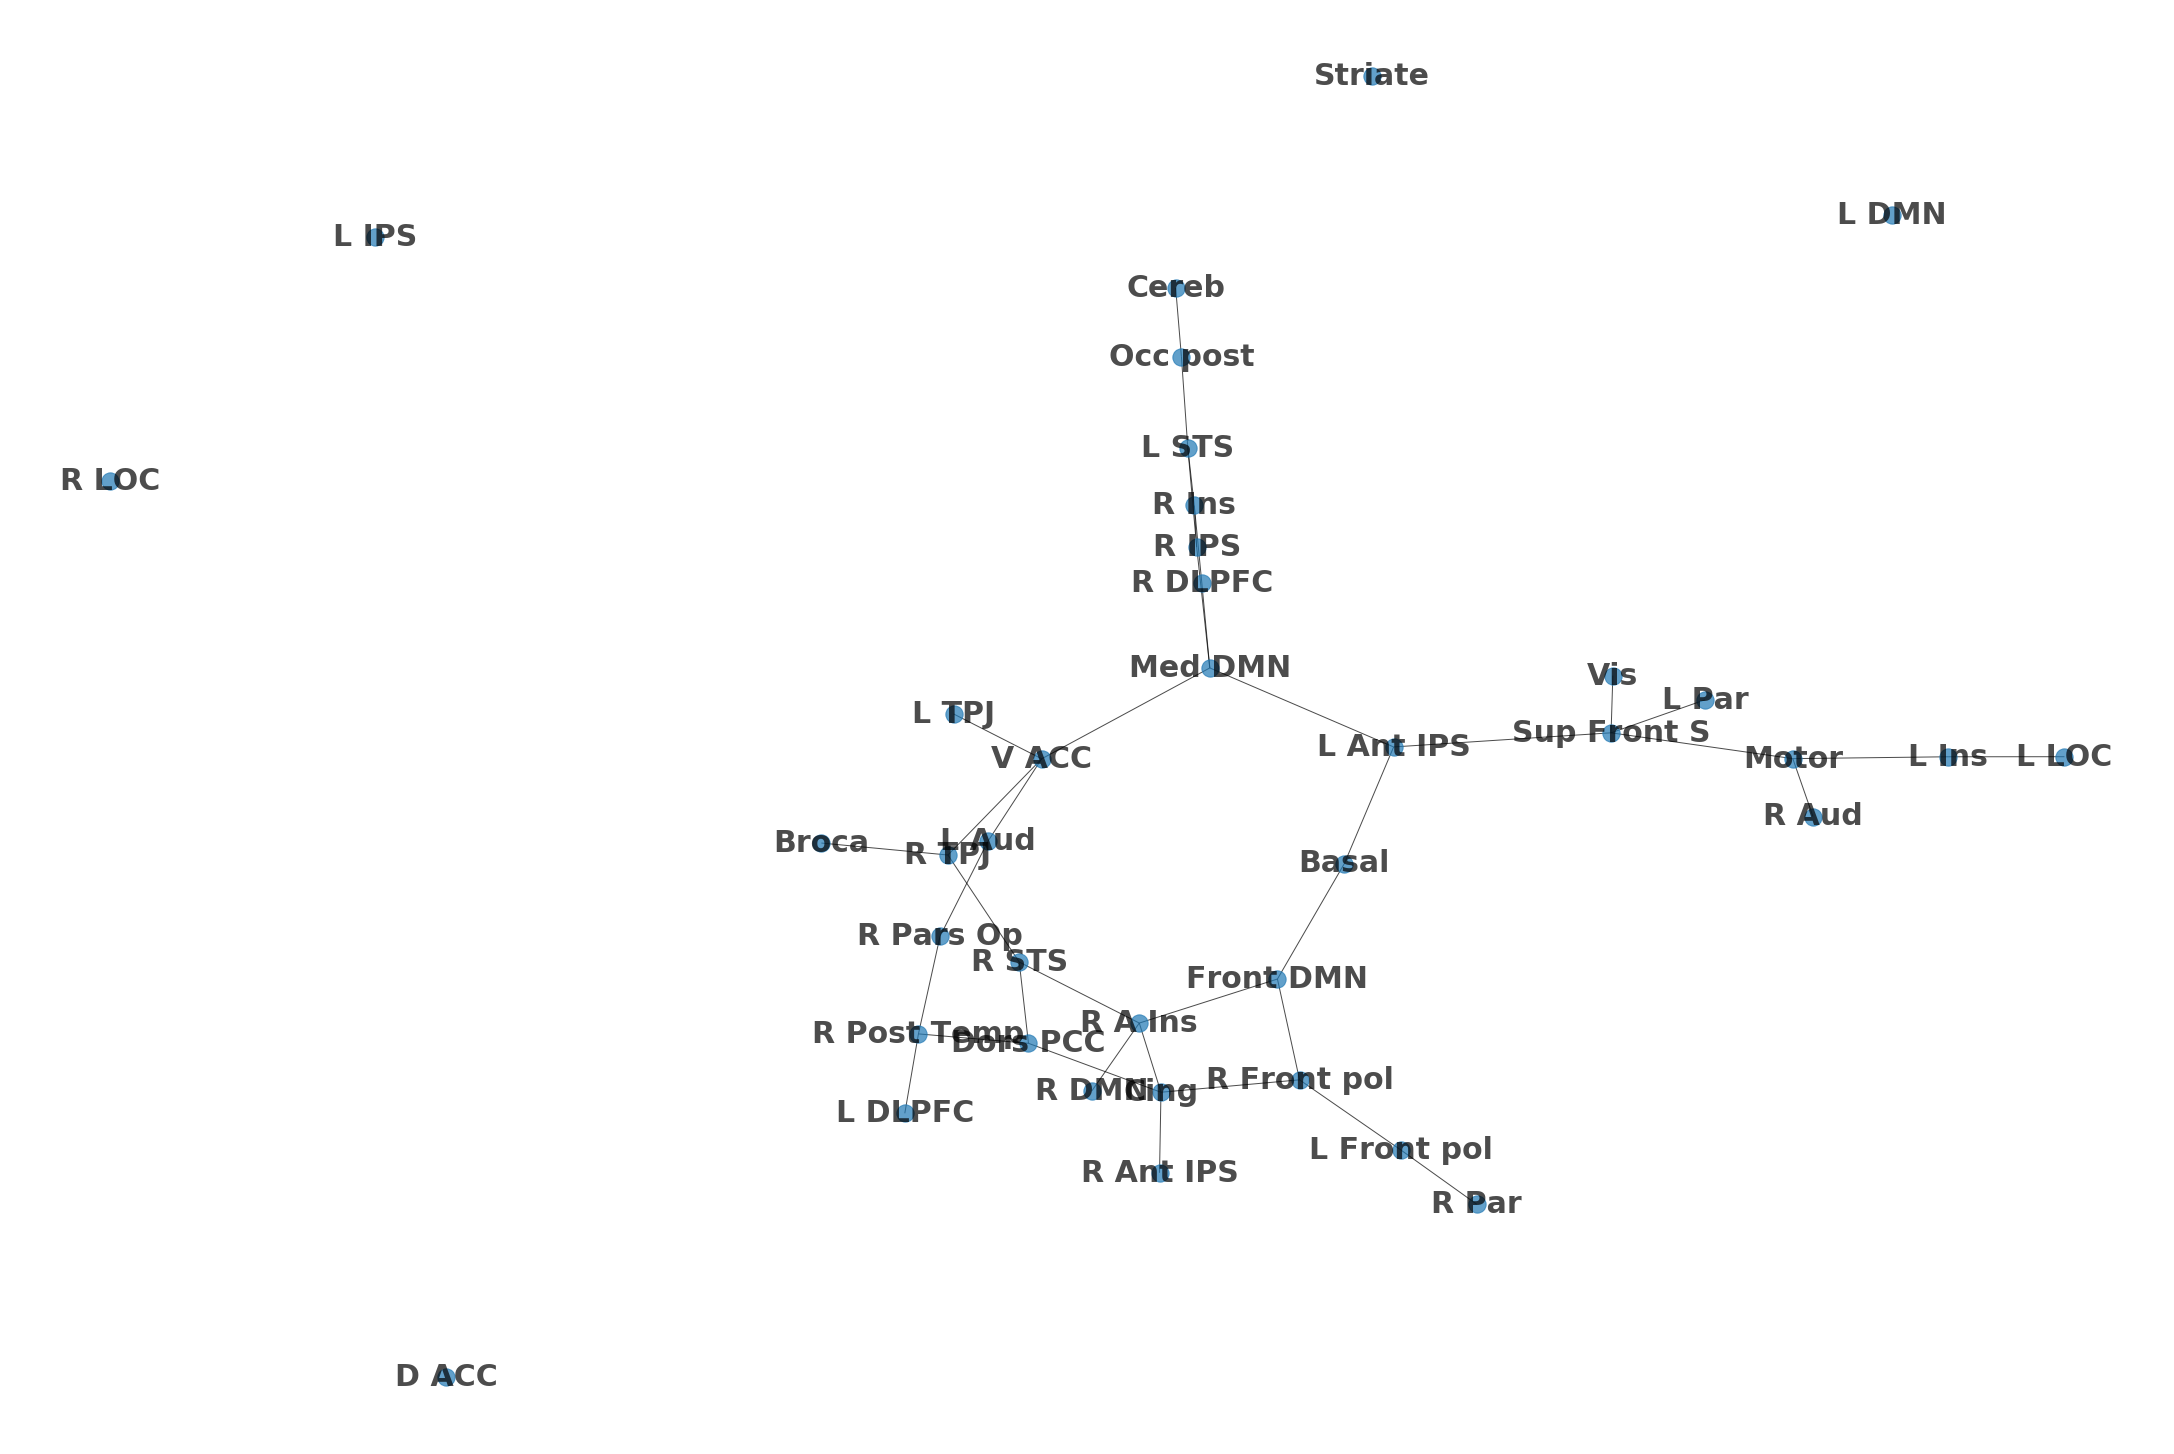

In [25]:
# drawing the adajency matrix
import matplotlib.pyplot as plt
plt.figure(figsize=(30,20))
nx.draw(G, with_labels=True, font_size = 30, width = 1, alpha = 0.7, font_weight = "bold")

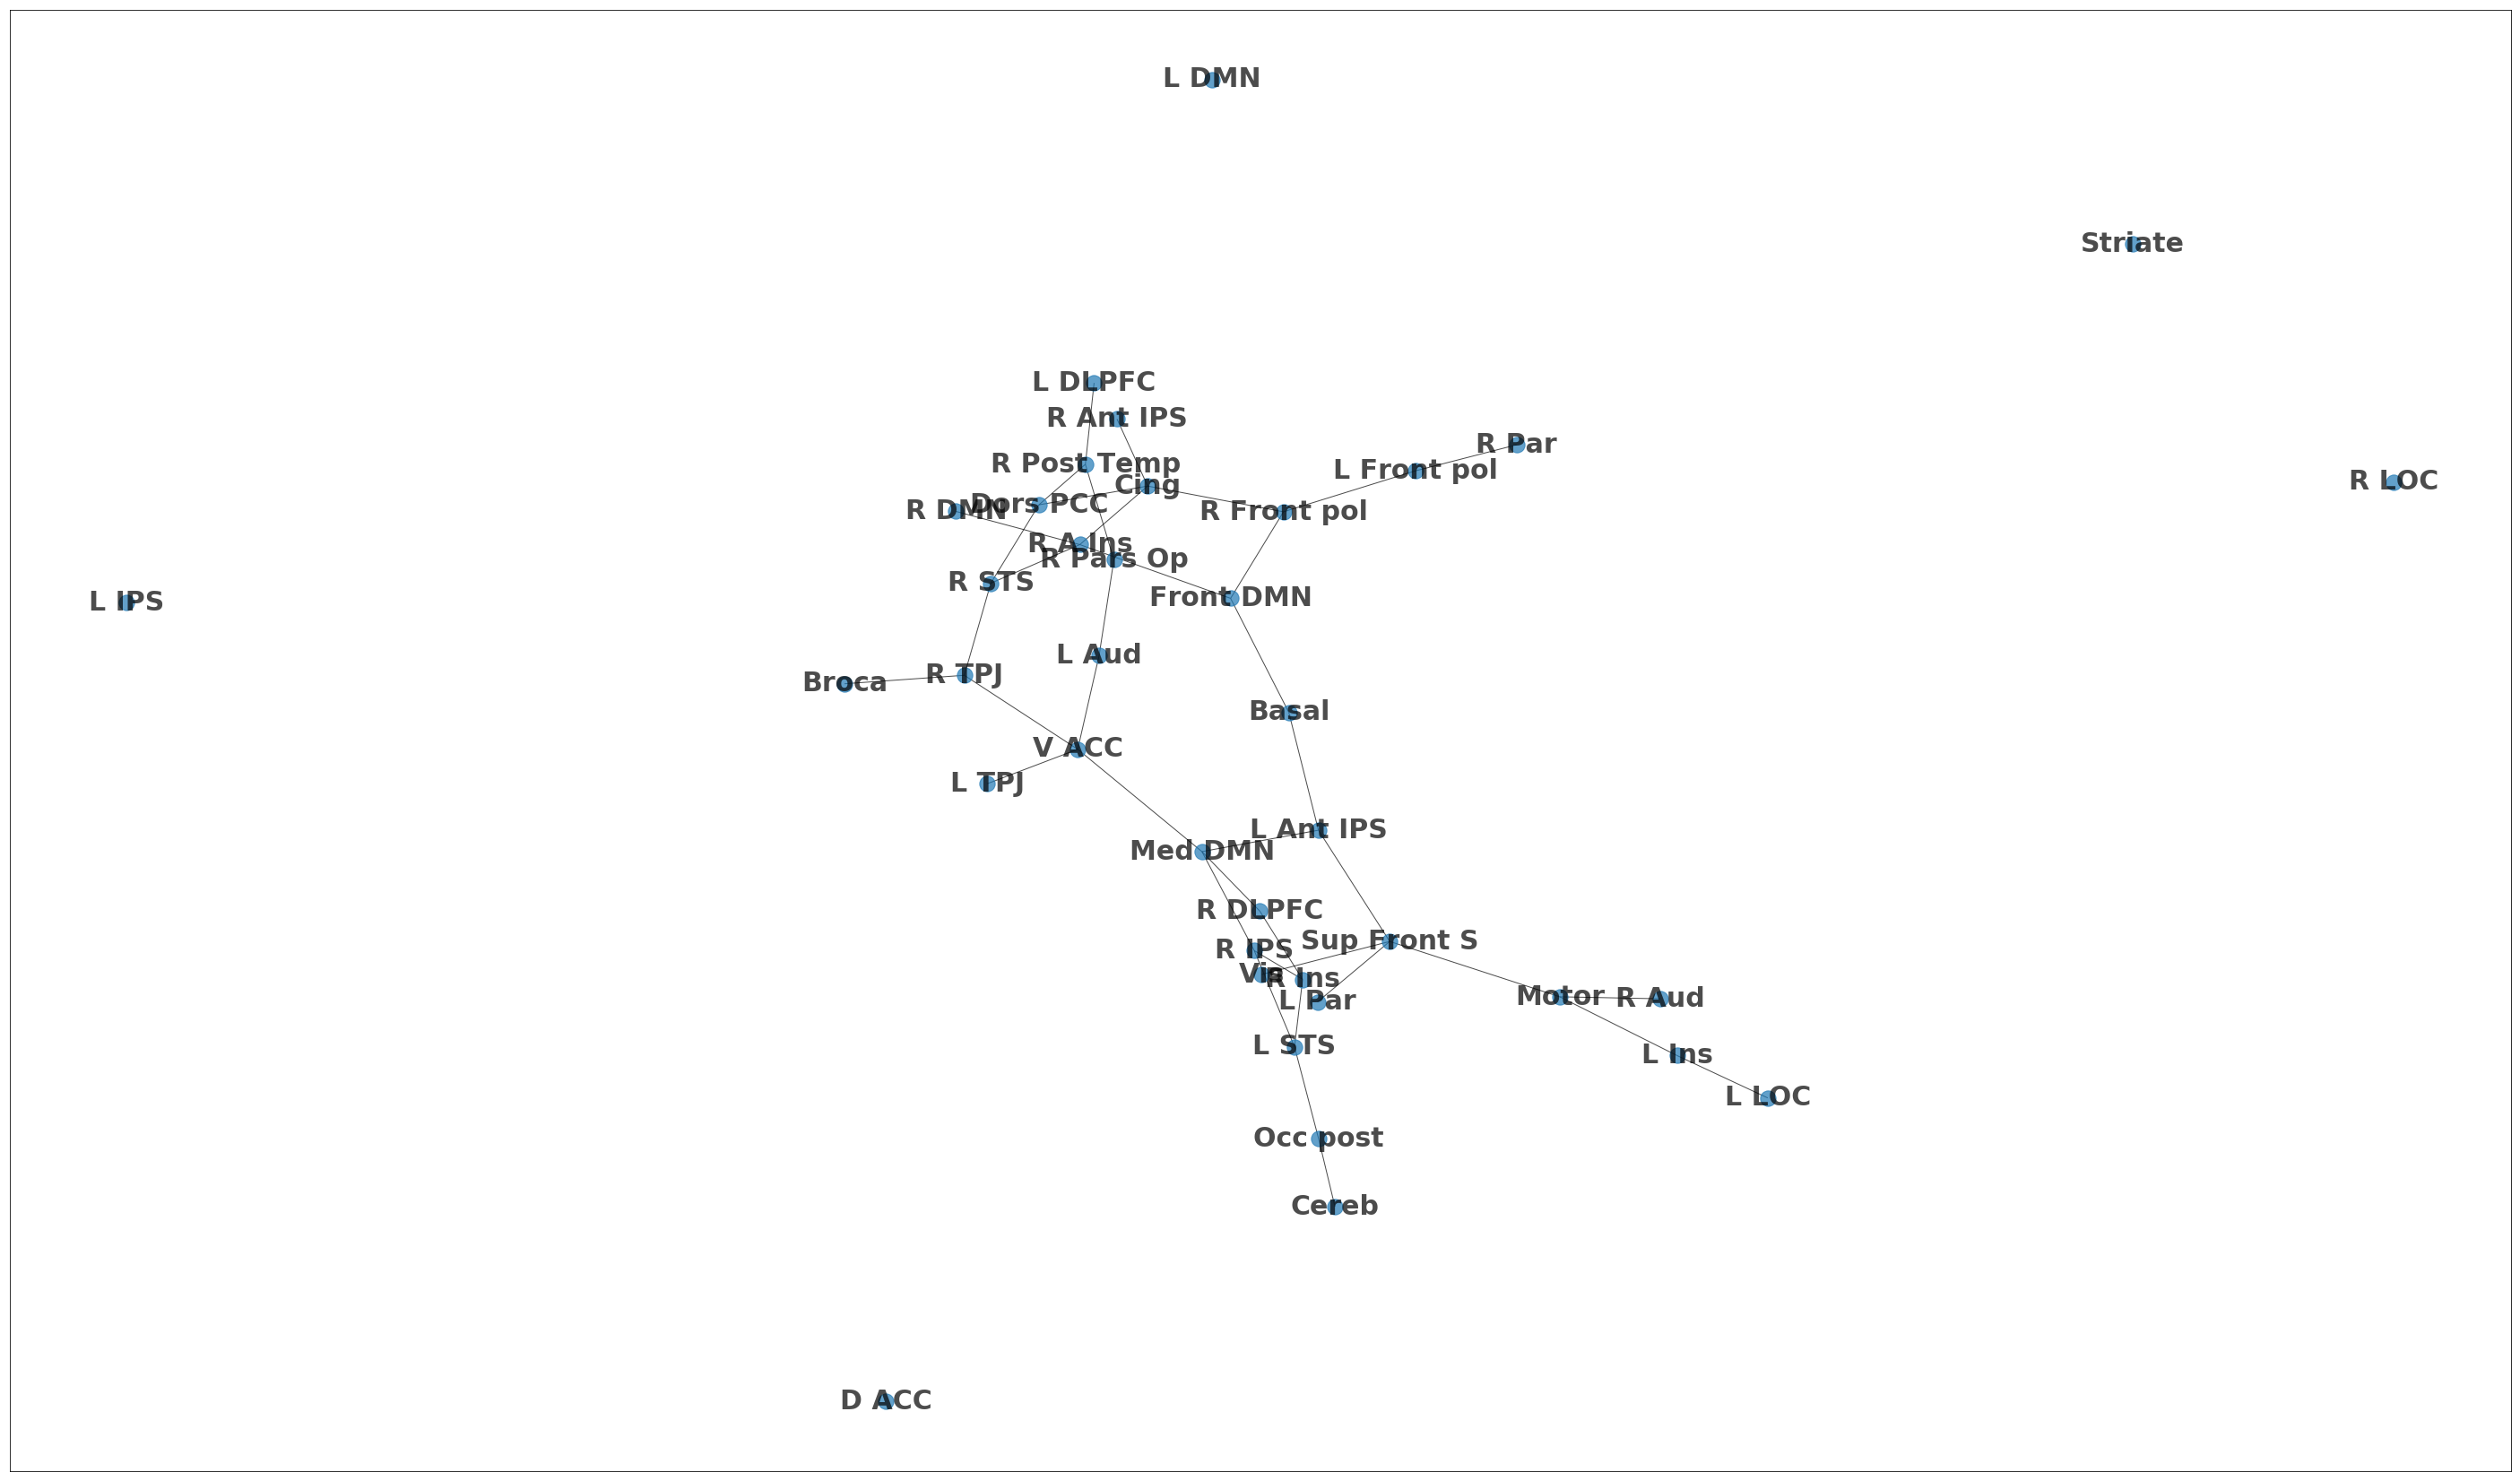

In [26]:
plt.figure(figsize=(50,30))
nx.draw_networkx(G, with_labels=True, font_size = 30, width = 1, alpha = 0.7, font_weight = "bold")

In [27]:
# check centrality and take the highest four
import operator

a= nx.degree_centrality(G) # using networkX to check centrality of nodes.
sorted_x = sorted(a.items(), key=operator.itemgetter(1),reverse=True)
print(sorted_x)



[('Med DMN', 0.10526315789473684), ('V ACC', 0.10526315789473684), ('R A Ins', 0.10526315789473684), ('Sup Front S', 0.10526315789473684), ('Cing', 0.10526315789473684), ('Front DMN', 0.07894736842105263), ('Motor', 0.07894736842105263), ('R Front pol', 0.07894736842105263), ('R Post Temp', 0.07894736842105263), ('R IPS', 0.07894736842105263), ('L STS', 0.07894736842105263), ('R STS', 0.07894736842105263), ('R TPJ', 0.07894736842105263), ('Dors PCC', 0.07894736842105263), ('R Ins', 0.07894736842105263), ('L Ant IPS', 0.07894736842105263), ('L Aud', 0.05263157894736842), ('Occ post', 0.05263157894736842), ('R DLPFC', 0.05263157894736842), ('Basal', 0.05263157894736842), ('L Front pol', 0.05263157894736842), ('R Pars Op', 0.05263157894736842), ('L Ins', 0.05263157894736842), ('R Aud', 0.02631578947368421), ('R DMN', 0.02631578947368421), ('R Par', 0.02631578947368421), ('L Par', 0.02631578947368421), ('L DLPFC', 0.02631578947368421), ('L LOC', 0.02631578947368421), ('Vis', 0.026315789473

In [ ]:
pvalMid, adjMid, _ = nbs.nbs_bct(mid1Reshape, mid2Reshape, thresh=2.5, tail='both',k=1000, paired=True, verbose = True)


In [ ]:
print(pvalMid.shape)
print (pvalMid)

Midazolam has no significant change between first day and 7 or 30 days.
Lets check differences between ket and mid.

In [ ]:
pvalKetMid, adjKetMid, _ = nbs.nbs_bct(ket2Reshape, mid2Reshape, thresh=2.5, tail='both',k=1000, paired=False, verbose = True)


In [ ]:
print(pvalKetMid.shape)
print (pvalKetMid)
# no difference between ketamine and midazolam. 


In [28]:
# for the sake of QA we can create histogram plots of correlation matrices
import matplotlib.pyplot as plt
import seaborn as sns


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [ ]:
### Check Denoising - all should be aroung zero
# Run analysis on all ket subjects
#color = sns.cubehelix_palette(len(ket1_corr),8)
#color = sns.palplot(sns.color_palette("RdBu_r", len(ket1_corr)))
sns.set_palette("husl") # set color pallet
correlation_vec = ConnectivityMeasure(kind='correlation', vectorize=True) # can choose partial - it might be better
    
# create correlation matrix for each subject
fullVec = []
for time_s in ket3_series:
    cor = correlation_vec.fit_transform([time_s])[0]
    print(cor.shape)
    plt.hist(cor, alpha = 0.3)
    fullVec.append(cor)


In [43]:
# build adjacency matrox for Time 0

# building an average array
avArr = np.average(ket1_corr, axis = 0)
B = ((avArr < -0.2) | (avArr>0.2))
B.astype(np.int)
print(B)

[[ True  True False ... False False False]
 [ True  True False ... False False False]
 [False False  True ... False False False]
 ...
 [False False False ...  True False False]
 [False False False ... False  True  True]
 [False False False ... False  True  True]]


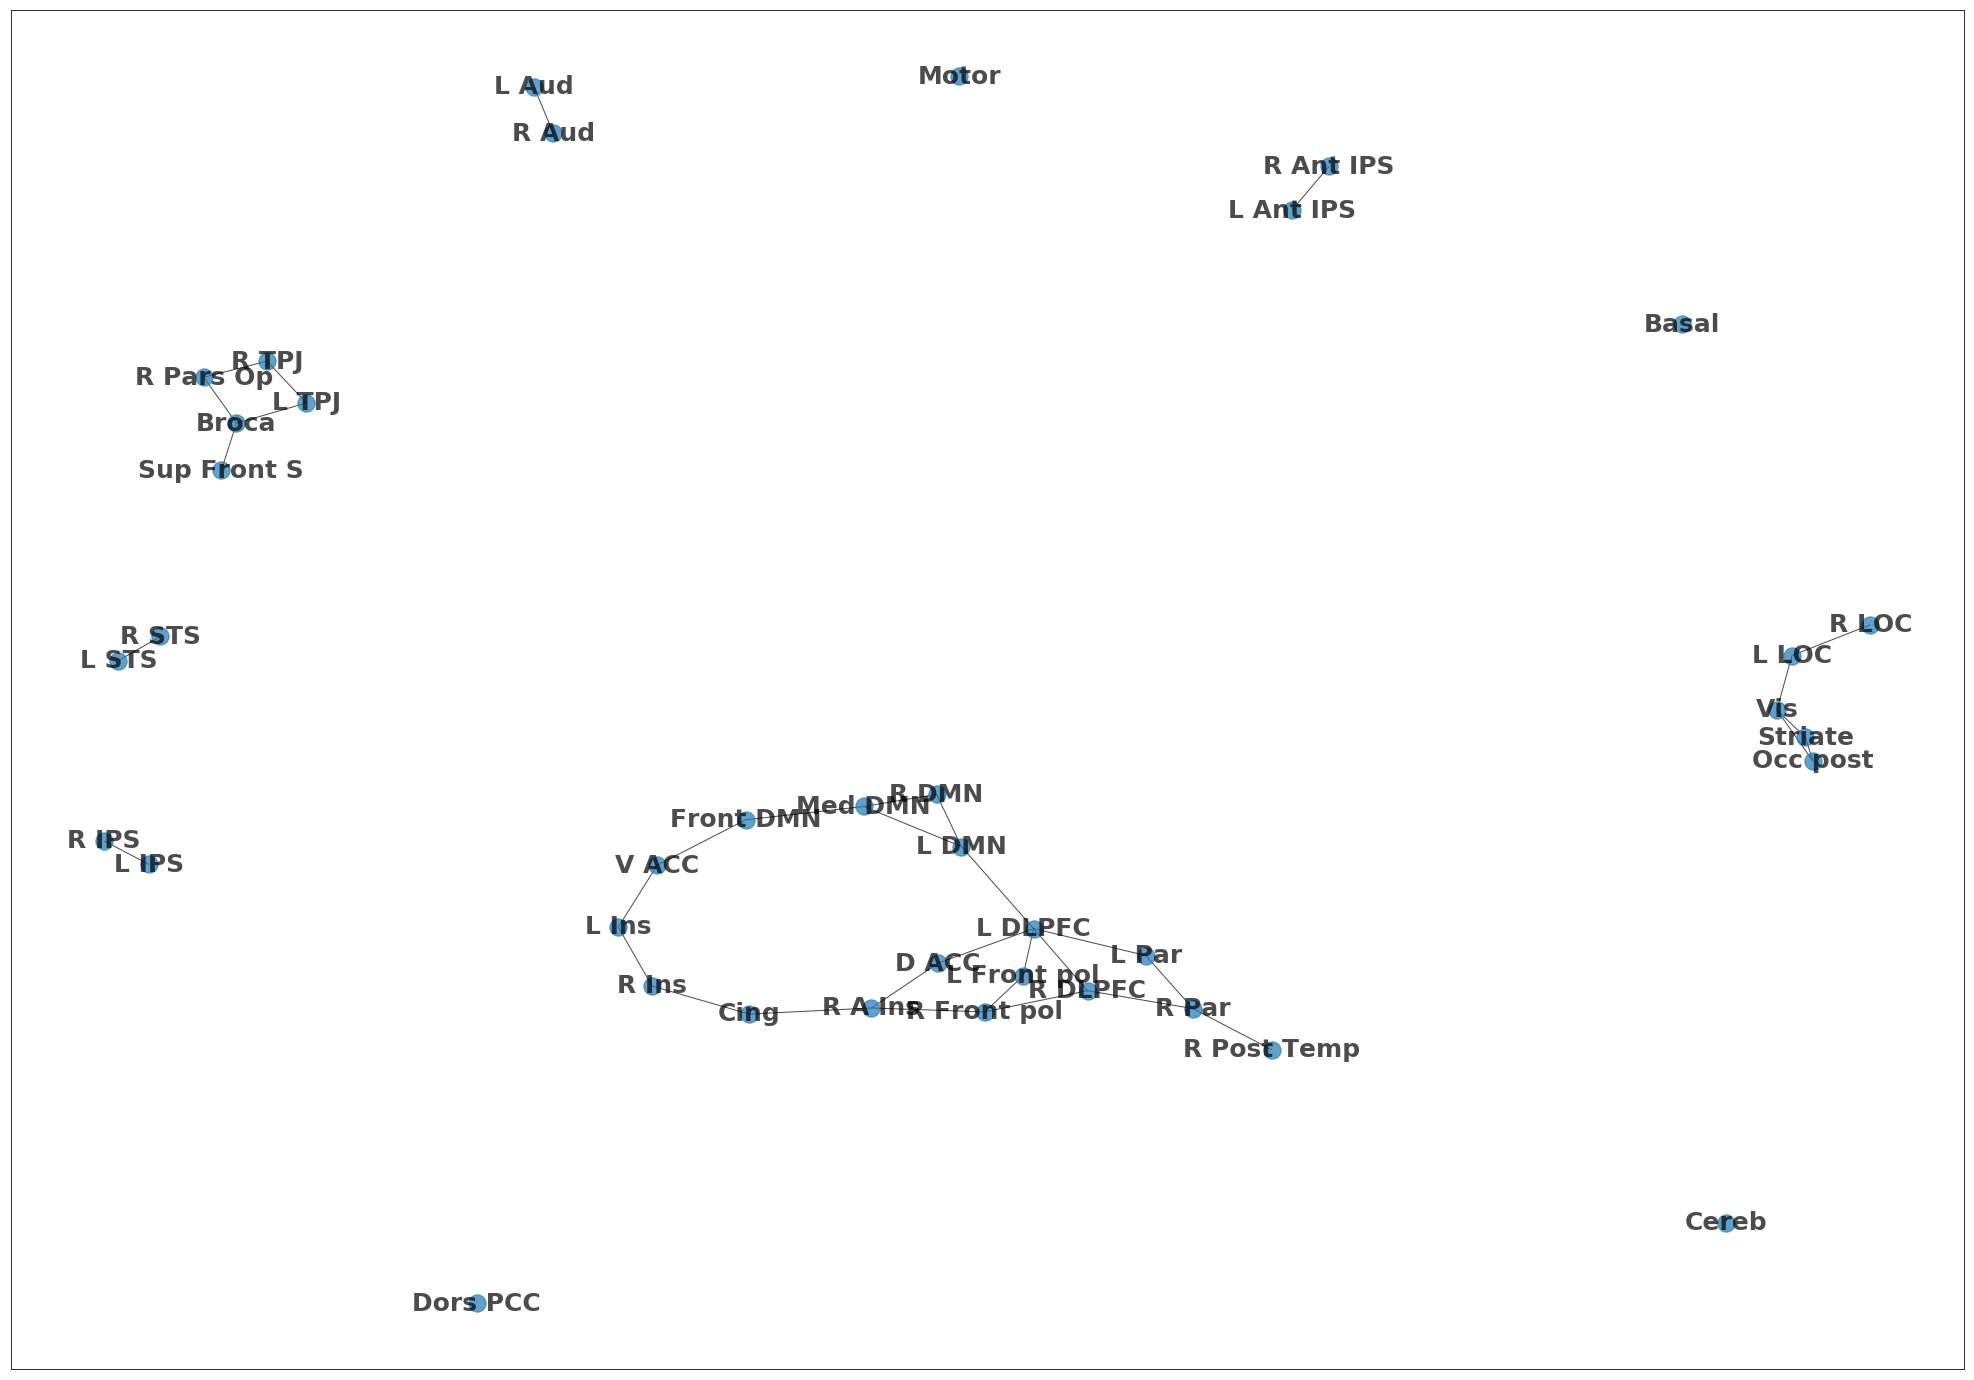

In [59]:
# This is a presentation of the adjacency matrix at Time 1 - before treatment. 
Dat = pd.DataFrame(B.astype(np.int), columns=labels,index=labels)

G2 = nx.from_pandas_adjacency(Dat)
plt.figure(figsize=(35,25))
nx.draw_networkx(G2, with_labels=True, font_size = 25, width = 1, alpha = 0.7, font_weight = "bold")

In [60]:
# using adjacency matrix - take the real correaltion differences 
ketDeltaA = []
b = ad
for ket in (ket3_ket1):
    g = np.zeros([39,39])
    print(ket[b!=0])
    g[b!=0] = ket[b!=0]
    ketDeltaA.insert(len(ketDeltaA),g)
    
np.array(ketDeltaA).shape  
#print(f"First {np.array(ketDeltaA)[0,:,0:10]}")
#print(f"Sec {np.array(ketDeltaA)[1,:,0:10]}")
    
# This vectors (one per subject) will use for regression analysis, after we exclude all zeros from them (see below)

[-0.03983419 -0.0293757   0.0755849   0.20539075 -0.1195279   0.09233415
  0.08252802  0.16290471 -0.0443337  -0.14679196  0.24011121  0.00123395
 -0.20236284  0.0755849   0.14171368 -0.12533686  0.20539075 -0.1215636
  0.16290471 -0.09063423  0.01140383  0.17924806  0.0742061   0.12953977
  0.01102647 -0.0443337   0.15154275 -0.00643213  0.0742061  -0.09063423
  0.17924806 -0.1195279   0.05206418 -0.01793038  0.13927375 -0.00810675
 -0.03983419  0.09233415  0.02395743  0.07374428 -0.14679196  0.24011121
 -0.24483092 -0.10087672  0.00123395  0.05206418 -0.34980539 -0.24483092
 -0.12932286  0.12579709  0.02395743  0.01863874  0.14171368 -0.00643213
 -0.00810675  0.34460022  0.07374428 -0.12932286  0.01863874 -0.0293757
  0.12953977 -0.20236284  0.01102647  0.12579709  0.33903725 -0.12533686
  0.13927375  0.01140383 -0.10087672  0.33903725  0.0968499  -0.1215636
 -0.01793038 -0.34980539  0.08252802  0.15154275  0.34460022  0.0968499 ]
[ 0.030739   -0.0805402  -0.08108765  0.16771557 -0.0

(8, 39, 39)

In [61]:
# creating same vector for midazolam group - just to help us comparing
midDeltaA = []
b = ad
for ket in (mid3_mid1):
    g = np.zeros([39,39])
    print(ket[b!=0])
    g[b!=0] = ket[b!=0]
    midDeltaA.insert(len(midDeltaA),g)
    
np.array(midDeltaA).shape  

[ 0.02849496 -0.06241438 -0.34941168 -0.06362689 -0.01146998  0.1828111
 -0.24625757  0.17698909 -0.14082181 -0.15990357  0.27991148 -0.08789662
 -0.08772562 -0.34941168  0.20728043  0.11817306 -0.06362689  0.23660373
  0.17698909 -0.00267657  0.07961377  0.04949062  0.1904886  -0.10886673
  0.04357287 -0.14082181  0.11055122  0.14946968  0.1904886  -0.00267657
  0.04949062 -0.01146998  0.07477569 -0.10550349 -0.108378    0.0589272
  0.02849496  0.1828111  -0.00965255 -0.04264887 -0.15990357  0.27991148
  0.06105494  0.08023204 -0.08789662  0.07477569 -0.26677819  0.06105494
 -0.05147641 -0.05836616 -0.00965255  0.08197879  0.20728043  0.14946968
  0.0589272  -0.09019081 -0.04264887 -0.05147641  0.08197879 -0.06241438
 -0.10886673 -0.08772562  0.04357287 -0.05836616 -0.2026018   0.11817306
 -0.108378    0.07961377  0.08023204 -0.2026018   0.23680809  0.23660373
 -0.10550349 -0.26677819 -0.24625757  0.11055122 -0.09019081  0.23680809]
[-0.15397549  0.06592374  0.13904709  0.27525271  0.

(7, 39, 39)

In [ ]:
p = ([1,2,3],[4,5,6], [7,8,9])
q = ([1,2,7],[4,5,9])
x = ([0,0,1],[0,0,1])
x= np.array(x)
p = np.array(p)
print(p)
print(p.reshape(-1))


    

In [62]:
allDeltaA = ketDeltaA + midDeltaA # combine all together
np.array(allDeltaA).shape

(15, 39, 39)

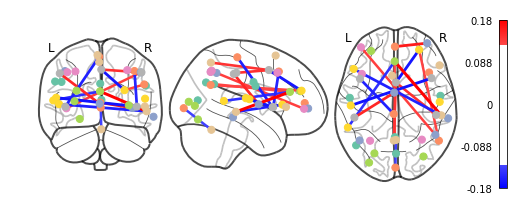

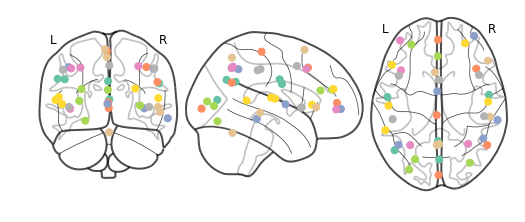

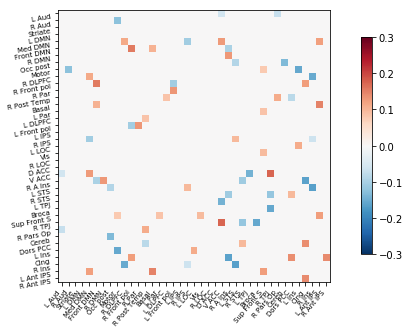

In [193]:
# We will build a simple average matrix (ket3 - ket1) according to the adjacency matrix (39,39) in order to vizualize
# results on the nodes themselves
ket3_1_average = np.average(np.array(ket3_ket1), axis = 0)

# now we replace all 1 in adj to real values and zeros will remain zeros
j = adj
j[j!=0] = ket3_1_average[j!=0] # replacing j values in real difference instead of 1
# now we can plot

plotting.plot_connectome(j, coords,
                        edge_threshold="98%", colorbar=True)#, output_file="Ket3_vsKet1.png")
a = np.zeros((39,39))
plotting.plot_connectome(a, coords,
                        edge_threshold="100%") #, colorbar=True)#, output_file="Ket3_vsKet1.png")


plotting.plot_matrix(j, labels=labels, colorbar=True,
                     vmax=0.3, vmin=-0.3)

/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/seaborn/palettes.py:777: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))


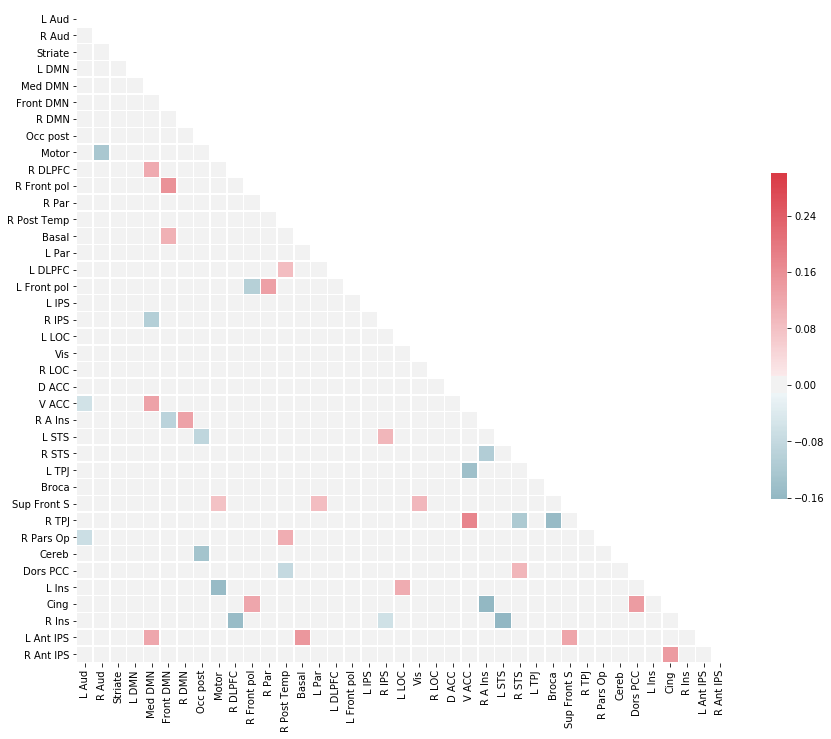

In [64]:
# this is a small snippet of code that takes the adajecnt's matrix that was created before and present it in diagonal 
# correlation matrix. 
#  change it into dataframe to add labels (using atlas labels)
import pandas as pd
d = pd.DataFrame(data=j,
                 columns=labels, index=labels)

mask = np.zeros_like(d, dtype=np.bool) # masking half
mask[np.triu_indices_from(mask)] = True


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns_plot = sns.heatmap(d, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})



In [65]:
# need to build regression model according to this vector for each subject
# change from matrix to vector
vecKetamin = [] # vector of all edges per subject
for i in ketDeltaA:
    # create a data frame 
    df = pd.DataFrame(i)
    # masking on diagonal (to avoid repeated numbers)
    dataCorr = df.mask(np.tril(np.ones(df.shape)).astype(np.bool))
    # remove less than 0.001
    dataCorr = dataCorr[abs(dataCorr) >= 0.001].stack().reset_index()
    a = np.array(dataCorr[0]).reshape(-1) # reshaping subject matrix to vector
    #print(a[a!=0]) 
    vecKetamin.append(a) # appending everything that's not zero 
np.array(vecKetamin).shape # shape of vector (subjects,length)


(8,)

In [75]:
vecMid = [] # vector of all edges per subject
for i in midDeltaA:
    # create a data frame 
    df = pd.DataFrame(i)
    # masking on diagonal (to avoid repeated numbers)
    dataCorr = df.mask(np.tril(np.ones(df.shape)).astype(np.bool))
    # remove less than 0.001
    dataCorr = dataCorr[abs(dataCorr) >= 0.001].stack().reset_index()
    a = np.array(dataCorr[0]).reshape(-1) # reshaping subject matrix to vector
    #print(a[a!=0]) 
    vecMid.append(a) # appending everything that's not zero 
np.array(vecMid).shape # shape of vector (subjects,length)
print(vecMid)

[array([ 0.02849496, -0.06241438, -0.34941168, -0.06362689, -0.01146998,
        0.1828111 , -0.24625757,  0.17698909, -0.14082181, -0.15990357,
        0.27991148, -0.08789662, -0.08772562,  0.20728043,  0.11817306,
        0.23660373, -0.00267657,  0.07961377,  0.04949062,  0.1904886 ,
       -0.10886673,  0.04357287,  0.11055122,  0.14946968,  0.07477569,
       -0.10550349, -0.108378  ,  0.0589272 , -0.00965255, -0.04264887,
        0.06105494,  0.08023204, -0.26677819, -0.05147641, -0.05836616,
        0.08197879, -0.09019081, -0.2026018 ,  0.23680809]), array([-0.15397549,  0.06592374,  0.13904709,  0.27525271,  0.1050112 ,
       -0.12002054,  0.13519482,  0.18263843, -0.27560097, -0.07833056,
        0.09442743,  0.10815398, -0.07787202, -0.28191213,  0.14133964,
       -0.08829192, -0.41988391, -0.07607641, -0.00628711, -0.12699965,
        0.00761254,  0.42447613,  0.11975384,  0.01274765,  0.08684652,
       -0.23073113, -0.07346559,  0.10493851, -0.08161246, -0.14085007,
  

In [67]:
# # sorting correlation vector - using key=abs for absolute values
vecSort = []
for i in vecKetamin:
    print(f"Original {i}")
    a = sorted(i, key=abs, reverse=True)
    print(f"New {a}")
    vecSort.append(a)
print(np.array(vecSort).shape)

Original [-0.03983419 -0.0293757   0.0755849   0.20539075 -0.1195279   0.09233415
  0.08252802  0.16290471 -0.0443337  -0.14679196  0.24011121  0.00123395
 -0.20236284  0.14171368 -0.12533686 -0.1215636  -0.09063423  0.01140383
  0.17924806  0.0742061   0.12953977  0.01102647  0.15154275 -0.00643213
  0.05206418 -0.01793038  0.13927375 -0.00810675  0.02395743  0.07374428
 -0.24483092 -0.10087672 -0.34980539 -0.12932286  0.12579709  0.01863874
  0.34460022  0.33903725  0.0968499 ]
New [-0.3498053904358568, 0.3446002203226192, 0.33903724780828903, -0.24483091591000067, 0.24011121260319535, 0.20539075339751758, -0.20236284388992853, 0.17924805841377522, 0.16290471147459246, 0.1515427530784298, -0.14679195918776858, 0.1417136836936027, 0.1392737531360397, 0.12953977107567038, -0.1293228607596681, 0.1257970886646199, -0.1253368556214922, -0.12156360059533458, -0.11952789675837061, -0.10087672094147108, 0.09684990153962955, 0.09233415436086695, -0.09063423141490815, 0.08252802481791024, 0.07

In [76]:
midSort = []
for i in vecMid:
    print(f"Original {i}")
    a = sorted(i, key=abs, reverse=True)
    print(f"New {a}")
    midSort.append(a)
print(np.array(midSort).shape)

Original [ 0.02849496 -0.06241438 -0.34941168 -0.06362689 -0.01146998  0.1828111
 -0.24625757  0.17698909 -0.14082181 -0.15990357  0.27991148 -0.08789662
 -0.08772562  0.20728043  0.11817306  0.23660373 -0.00267657  0.07961377
  0.04949062  0.1904886  -0.10886673  0.04357287  0.11055122  0.14946968
  0.07477569 -0.10550349 -0.108378    0.0589272  -0.00965255 -0.04264887
  0.06105494  0.08023204 -0.26677819 -0.05147641 -0.05836616  0.08197879
 -0.09019081 -0.2026018   0.23680809]
New [-0.34941167860822236, 0.2799114820500718, -0.26677818905602435, -0.24625757491337028, 0.23680809414053694, 0.23660372944777364, 0.20728043189916967, -0.20260180019779797, 0.1904886035522954, 0.18281110259871358, 0.1769890930856483, -0.15990356681623513, 0.14946967889514642, -0.14082180534393607, 0.11817306344577921, 0.11055122340121101, -0.10886672736157732, -0.10837799508681467, -0.10550349389781022, -0.09019081080361518, -0.08789661702369925, -0.08772562155422263, 0.08197879477195799, 0.0802320375245305,

In [79]:
# create a vector for all of them toghether
vecAll = vecSort + midSort# vector of all edges per subject
print(np.array(vecAll).shape)

(15,)


In [111]:
# lets run regression model to try and predict PCL scores with connectivity vector
# first load up pcl data
kpe_dat = pd.read_excel('/home/oad4/Documents/kpe_analysis/KPEIHR0009_data_all_scored.xlsx', index_col ="scr_id")
print(kpe_dat)

/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/xlrd/xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


         med_cond  scr_dem_gender  scr_dem_hand scr_dem_lang  scr_dem_age  \
scr_id                                                                      
KPE008        1.0             1.0           1.0      Spanish         51.0   
KPE1223       1.0             1.0           1.0      Spanish         31.0   
KPE1253       0.0             1.0           1.0      English         26.0   
KPE1263       0.0             0.0           1.0      English         29.0   
KPE1293       1.0             0.0           1.0      English         41.0   
KPE1307       1.0             0.0           1.0      English         44.0   
KPE1315       1.0             1.0           1.0      English         52.0   
KPE1322       1.0             1.0           1.0      English         63.0   
KPE1339       1.0             0.0           1.0      English         34.0   
KPE1343       1.0             1.0           1.0      English         30.0   
KPE1351       0.0             0.0           0.0      English         55.0   

In [113]:
import statistics 
# subset the data frame
kpe_pcl = kpe_dat[['med_cond','pcl5_total_screen','pcl5_total_visit1', 'pcl5_total_visit7', 'pcl5_total_followup1','pcl5_total_followup2']] 
# remove NaN's from FU2
for i,n in enumerate(kpe_pcl['pcl5_total_followup2']):
    if  pd.isna(n) == True:
        print('nan')
        print(kpe_pcl['pcl5_total_followup2'][i])
        kpe_pcl['pcl5_total_followup2'][i]= np.nanmean(kpe_pcl['pcl5_total_followup2'])
# remove NaN's from visit 1
for i,n in enumerate(kpe_pcl['pcl5_total_visit1']):
    if  pd.isna(n) == True:
        print('nan')
        print(kpe_pcl['pcl5_total_visit1'][i])
        kpe_pcl['pcl5_total_visit1'][i]= kpe_pcl['pcl5_total_screen'][i] # replace with screening data
    
# add change in PCL
kpe_pcl["PCLChange_3_1"] = kpe_pcl['pcl5_total_followup2'] - kpe_pcl["pcl5_total_visit1"]
print(kpe_pcl)
np.nanmean(kpe_pcl['pcl5_total_followup2'])

nan
nan
nan
nan


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
         med_cond  pcl5_total_screen  pcl5_total_visit1  pcl5_total_visit7  \
scr_id                                                                       
KPE008        1.0                 51               58.0                 61   
KPE1223       1.0                 39               41.0                 50   
KPE1253       0.0                 58               63.0                 58   
KPE1263       0.0                 21               54.0                 56   
KPE1293       1.0                 33               36.0                  6   
KPE1307       1.0                 56               49.0                 41   
KPE1315       1.0                 40               38.0                  8   
KPE1322       1.0                 45               56.0                 22   
KPE1339       1.0                 68               68.0                 65   
KPE1343       1.0                 28               38.0                 20   
KPE1351       0.0       

/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


35.13333333333333

In [115]:
# now lets build regression model
# Y = pcl score at FU2
# X's = vector of edges from each subject
kpe_data_pcl = kpe_pcl.loc[['KPE008','KPE1293','KPE1307','KPE1322','KPE1339','KPE1343','KPE1387','KPE1223']]
print(kpe_data_pcl)

         med_cond  pcl5_total_screen  pcl5_total_visit1  pcl5_total_visit7  \
scr_id                                                                       
KPE008        1.0                 51               58.0                 61   
KPE1293       1.0                 33               36.0                  6   
KPE1307       1.0                 56               49.0                 41   
KPE1322       1.0                 45               56.0                 22   
KPE1339       1.0                 68               68.0                 65   
KPE1343       1.0                 28               38.0                 20   
KPE1387       1.0                 32               47.0                 46   
KPE1223       1.0                 39               41.0                 50   

         pcl5_total_followup1  pcl5_total_followup2  PCLChange_3_1  
scr_id                                                              
KPE008                   56.0                  49.0           -9.0  
KPE1293     

In [117]:
# take the highest centrality nodes and their change of correlation
#print(sorted_x) # printing the highest centrality values
# get locations of each
print(labels.index("Dors PCC"))
print(labels.index("Cing"))
np.array(ketDeltaA)[:,4,23] # V ACC and Med DMN
np.array(ketDeltaA)[:,33,35] # Dors PCC" and Cing

centVec = pd.DataFrame(np.array(ketDeltaA)[:,4,23], index = su)
centVec['1'] = np.array(ketDeltaA)[:,33,35]
#centVec['2'] = 
centVec.iloc[:,0:2]


33
35


NameError: name 'su' is not defined

In [118]:
import statsmodels.api as sm

X = centVec.iloc[:,0:2] #kpe_matrix_dat[1]
y = kpe_data_pcl["PCLChange_3_1"]

X = sm.add_constant(X)
# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())

/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


NameError: name 'centVec' is not defined

In [119]:
su = ['KPE008','KPE1293','KPE1307','KPE1322','KPE1339','KPE1343','KPE1387','KPE1223']

kpe_matrix_dat = pd.DataFrame(vecSort, index=su)#pd.DataFrame(vecKetamin, index=su)
print(kpe_matrix_dat.iloc[:,0:39])
# now we have flatten the matrix. 
# Remember, we now have double of everything, saw basically should split it in half. 


               0         1         2         3         4         5         6   \
KPE008  -0.349805  0.344600  0.339037 -0.244831  0.240111  0.205391 -0.202363   
KPE1293  0.378139  0.300373 -0.268445  0.256585 -0.246819 -0.241191  0.215647   
KPE1307  0.345121 -0.314481  0.293739 -0.259456 -0.245553 -0.242400  0.231846   
KPE1322  0.346065 -0.327931  0.313158  0.302770  0.286657  0.273398  0.252285   
KPE1339  0.216665  0.209348  0.204065  0.201683  0.170291 -0.169423 -0.165696   
KPE1343  0.515088  0.329453 -0.288947 -0.278777 -0.275157  0.266390 -0.263303   
KPE1387  0.402890  0.347466  0.332712  0.300307  0.299919 -0.286617 -0.278096   
KPE1223 -0.409714 -0.375018  0.310130  0.282711  0.246417  0.243323  0.236067   

               7         8         9   ...        29        30        31  \
KPE008   0.179248  0.162905  0.151543  ... -0.039834 -0.029376  0.023957   
KPE1293 -0.211261  0.177358  0.167716  ...  0.054342  0.051678 -0.032738   
KPE1307 -0.222886  0.215741 -0.210512  ...

In [121]:
import statsmodels.api as sm

X = kpe_matrix_dat.iloc[:,0:2] #kpe_matrix_dat[1]
y = kpe_data_pcl["PCLChange_3_1"]

X = sm.add_constant(X)
# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          PCLChange_3_1   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     2.146
Date:                Mon, 13 May 2019   Prob (F-statistic):              0.212
Time:                        16:01:11   Log-Likelihood:                -29.918
No. Observations:                   8   AIC:                             65.84
Df Residuals:                       5   BIC:                             66.07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.2786      5.196     -1.978      0.1

/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


In [122]:
high = []
cord = []
ketDeltaA = np.array(ketDeltaA)
for i in ketDeltaA:
    h = max(i.min(), i.max(), key=abs) # need to take highest value in absolute value
    high.append(h)
    c = np.where(i == h)
    c = np.concatenate([c[0], c[1]])
    cord.append(c)
print(high)


[-0.34980539043585834, 0.3781385911012223, 0.34512143863952055, 0.3460646954399491, 0.2166648799846489, 0.5150878215368141, 0.4028896451347996, -0.40971391356717823]


In [123]:
# now we can get a list of connections for each subject
for i in cord:
    
    print (f"Subjcet first ROI is {labels[i[0]]}, second is {labels[i[1]]}")
    

Subjcet first ROI is R Ins, second is L STS
Subjcet first ROI is R TPJ, second is V ACC
Subjcet first ROI is R DMN, second is R A Ins
Subjcet first ROI is R TPJ, second is V ACC
Subjcet first ROI is L Par, second is Sup Front S
Subjcet first ROI is R Front pol, second is Front DMN
Subjcet first ROI is Cing, second is R Ant IPS
Subjcet first ROI is Cing, second is R A Ins


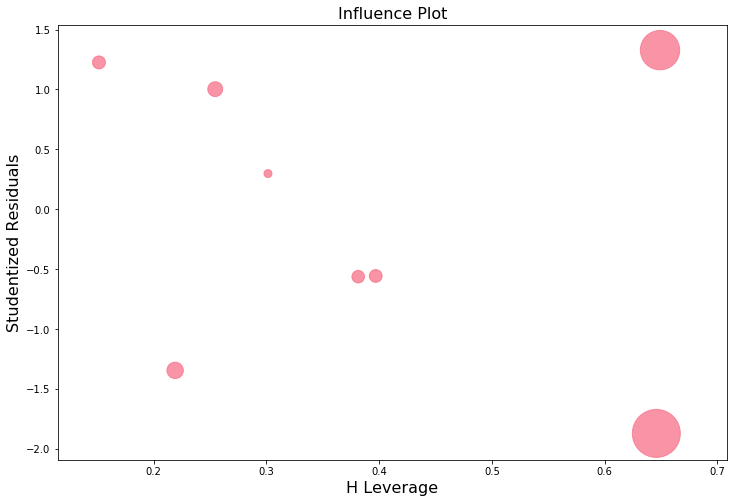

In [124]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(model, ax=ax, criterion="cooks")

In [125]:
kpe_all = kpe_data_pcl
kpe_all['highest'] = kpe_matrix_dat.iloc[:,0]
kpe_all['highest2'] = kpe_matrix_dat.iloc[:,1]


In [126]:
z= kpe_matrix_dat.iloc[:,0]
d = kpe_data_pcl["PCLChange_3_1"]
print(z)
print(high)
print (d)

KPE008    -0.349805
KPE1293    0.378139
KPE1307    0.345121
KPE1322    0.346065
KPE1339    0.216665
KPE1343    0.515088
KPE1387    0.402890
KPE1223   -0.409714
Name: 0, dtype: float64
[-0.34980539043585834, 0.3781385911012223, 0.34512143863952055, 0.3460646954399491, 0.2166648799846489, 0.5150878215368141, 0.4028896451347996, -0.40971391356717823]
scr_id
KPE008     -9.0
KPE1293   -33.0
KPE1307   -29.0
KPE1322   -29.0
KPE1339    -1.0
KPE1343   -19.0
KPE1387    -8.0
KPE1223     8.0
Name: PCLChange_3_1, dtype: float64


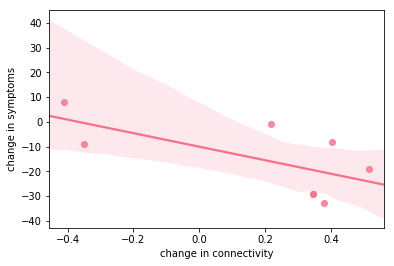

In [184]:
ax = sns.regplot(kpe_matrix_dat.iloc[:,0],d)
#ax.set_title('Correlation between highest change in connectivity and change in symptoms')
ax.set(xlabel='change in connectivity', ylabel='change in symptoms')
plt.show()
# sns.regplot(kpe_matrix_dat.iloc[:,1], d)
# plt.show()

# sns.regplot(high, d)
# plt.show()


In [128]:
# check pearson corelation between highest change in connectivity and PCL change in symptoms
import scipy as sc
#sc.stats.pearsonr(kpe_matrix_dat.iloc[:,77],d)
sc.stats.pearsonr(high,d)

(-0.6551008533879773, 0.07786724459201341)

KPE008    -0.349805
KPE1293    0.378139
KPE1307    0.345121
KPE1322    0.346065
KPE1339    0.216665
KPE1343    0.515088
KPE1387    0.402890
KPE1223   -0.409714
KPE1253   -0.349412
KPE1263    0.424476
KPE1351    0.437130
KPE1364    0.371548
KPE1369   -0.350616
KPE1390    0.319799
KPE1403    0.272360
Name: 0, dtype: float64
(-0.33871443680830665, 0.216852714888998)


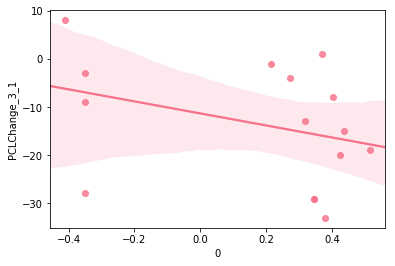

In [129]:
# check correlation for all subjects
all_data_pcl = kpe_pcl.loc[['KPE008','KPE1293','KPE1307','KPE1322','KPE1339','KPE1343','KPE1387','KPE1223','KPE1253','KPE1263','KPE1351','KPE1364','KPE1369','KPE1390','KPE1403']]
suAll = ['KPE008','KPE1293','KPE1307','KPE1322','KPE1339','KPE1343','KPE1387','KPE1223','KPE1253', 'KPE1263','KPE1351','KPE1364','KPE1369','KPE1390','KPE1403']

allHigh = pd.DataFrame(vecAll, index=suAll)
print(allHigh[0])

print(sc.stats.pearsonr(allHigh[0], all_data_pcl['PCLChange_3_1']))

sns.regplot(allHigh[0], all_data_pcl['PCLChange_3_1'])


In [141]:
allDF = pd.merge(all_data_pcl, allHigh, on=all_data_pcl.index, how='outer') # creating a unified data frame
print(allDF)

      key_0  med_cond  pcl5_total_screen  pcl5_total_visit1  \
0    KPE008       1.0                 51               58.0   
1   KPE1293       1.0                 33               36.0   
2   KPE1307       1.0                 56               49.0   
3   KPE1322       1.0                 45               56.0   
4   KPE1339       1.0                 68               68.0   
5   KPE1343       1.0                 28               38.0   
6   KPE1387       1.0                 32               47.0   
7   KPE1223       1.0                 39               41.0   
8   KPE1253       0.0                 58               63.0   
9   KPE1263       0.0                 21               54.0   
10  KPE1351       0.0                 40               40.0   
11  KPE1364       0.0                 48               51.0   
12  KPE1369       0.0                 55               52.0   
13  KPE1390       0.0                 38               38.0   
14  KPE1403       0.0                 17               

In [176]:
import statsmodels.formula.api as smf
allDF.rename(columns={(allDF.columns[8]):'first'}, inplace=True)
results = smf.ols('PCLChange_3_1 ~ first * med_cond', data=allDF).fit()

In [177]:
print(results.summary())



# seems like midazolam group doesn't have correlation between connectivity and changes of symptoms

                            OLS Regression Results                            
Dep. Variable:          PCLChange_3_1   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     1.773
Date:                Mon, 13 May 2019   Prob (F-statistic):              0.210
Time:                        16:25:37   Log-Likelihood:                -55.811
No. Observations:                  15   AIC:                             119.6
Df Residuals:                      11   BIC:                             122.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -12.5586      4.914     -2.

/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


In [ ]:
fix, ax = plt.subplots(figsize=(12,14))
fig = sm.graphics.plot_partregress("PCLChange_3_1", "highest", ["highest2"], data=kpe_all, ax=ax)

In [ ]:
allDF = kpe_data_pcl
allDF.merge(kpe_matrix_dat)
print(allDF)
#fig, ax = plt.subplots(figsize=(12,8))
#fig = sm.graphics.plot_partregress(kpe_matrix_dat[:,0], kpe_data_pcl["pcl5_total_followup2"], [kpe_matrix_dat[:,0:5],kpe_data_pcl["pcl5_total_followup2"]] , ax=ax)

In [ ]:
# writing results as .tex file (so we can convert later to PDF or PNG)
beginningtex = """\\documentclass{report}
\\usepackage{booktabs}
\\begin{document}"""
endtex = "\end{document}"

f = open('myreg.tex', 'w')
f.write(beginningtex)
f.write(model.summary().as_latex())
f.write(endtex)
f.close()

In [88]:
# doing same regression model for all subjects
# first data frame
all_data_pcl = kpe_pcl.loc[['KPE008','KPE1293','KPE1307','KPE1322','KPE1339','KPE1343','KPE1387','KPE1223','KPE1263','KPE1351','KPE1364','KPE1369','KPE1390','KPE1403']]

suAll = ['KPE008','KPE1293','KPE1307','KPE1322','KPE1339','KPE1343','KPE1387','KPE1223','KPE1263','KPE1351','KPE1364','KPE1369','KPE1390','KPE1403']

all_matrix_dat = pd.DataFrame(vecAll, index=suAll)

X = all_matrix_dat.iloc[:,0:5] #kpe_matrix_dat[1]
y = all_data_pcl["pcl5_total_followup2"]

X = sm.add_constant(X)
# Note the difference in argument order
modelAll = sm.OLS(y, X).fit()
predictions = modelAll.predict(X) # make the predictions by the model

# Print out the statistics
print(modelAll.summary())

ValueError: Shape of passed values is (15, 39), indices imply (14, 39)

In [ ]:
from sklearn import linear_model

lm = linear_model.LinearRegression()

# X = kpe_matrix_dat #kpe_matrix_dat[1]
# y = kpe_data_pcl["pcl5_total_followup2"]


X = kpe_matrix_dat
y = kpe_data_pcl["PCLChange_3_1"]
# define the data/predictors as the pre-set feature names  
#df = pd.DataFrame(kpe_matrix_dat)


print(X.shape)
print(y.shape)
model = lm.fit(X,y)

In [ ]:
predictions = lm.predict(X)

In [ ]:
print(predictions)

In [ ]:
lm.score(X,y)
# This leads to perfect prediction. So lets split data for test-retest

In [ ]:
from sklearn.model_selection import train_test_split
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)



In [ ]:
# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

In [ ]:
predictions

In [ ]:
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [ ]:
model.score(X_test, y_test)
# prediction is not great